In [138]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display
import soundfile as sf
import os
import pandas as pd
import seaborn as sns
import datetime

In [139]:

def remove_trailing_silence(audio_file):
    audio, sr = librosa.load(audio_file, sr= 32000, mono=True)
    clip = librosa.effects.trim(audio, top_db= 25)
    sf.write('filtered.wav', clip[0], 32000)
    
def extract_features(filepath, filter_level):
    audio, sr = librosa.load(filepath, sr= 32000, mono=True)
    clip = librosa.effects.trim(audio, top_db= 10)
    sf.write('filtered.wav', clip[0], 32000)
    f_s, signal = wavfile.read('filtered.wav')
    n_fft = int(0.025 * f_s)  # 25 ms
    hop_length = int(0.01 * f_s)  # 10 ms
    mel_spec = librosa.feature.melspectrogram(
        y=signal / 1.0, sr=f_s, n_mels=40,
        n_fft=n_fft, hop_length=hop_length
    )
    log_mel_spec = np.log(mel_spec)
    return log_mel_spec.T

def dtw(dist_mat):

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],  # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return path[::-1], cost_mat

def getCost(x_seq, y_seq):
    M = y_seq.shape[0]
    N = x_seq.shape[0]
    dist_mat = dist.cdist(x_seq, y_seq, "cosine")
    path, cost_mat = dtw(dist_mat)
    cost_mat_normalized = cost_mat / (M + N)

    return path, cost_mat, cost_mat_normalized

# Load training data

In [140]:
seq = []
clusters = []
filter_level=-25
trains=[]
filename=[]
for folder in os.listdir('./audio'):
    if 'wav' not in folder:
        cluster = folder
        trains.append(cluster)
        for file in os.listdir('./audio/' + folder):
            filename.append(file)
            signal_seq = extract_features('./audio/' + folder + '/' + file,filter_level)
            seq.append(signal_seq)
            clusters.append(cluster)
training = {'features': seq, 'labels': clusters, 'filename': filename}

# Load testing data

In [141]:
seq = []
clusters = []
filter_level=-25
tests=[]
filename=[]
for folder in os.listdir('./testing'):
    if 'wav' not in folder:
        cluster = folder
        tests.append(cluster)
        for file in os.listdir('./testing/' + folder):
            filename.append(file)
            signal_seq = extract_features('./testing/' + folder + '/' + file,filter_level)
            seq.append(signal_seq)
            clusters.append(cluster)
testing = {'features': seq, 'labels': clusters, 'filename': filename}

# Populate all comparisons, predictions and total evaluation

In [142]:
comp_test_label = []
comp_train_label = []
comp_cost = []
comp_filename=[]
comp_testfile=[]
pred_test_label = []
pred_train_label = []
pred_cost = []
start = datetime.datetime.now()
for test_label, test_seq, test_file in zip(testing['labels'], testing['features'], testing['filename']):
    min_cost = 10
    pred_label = ''
    for train_label, train_seq, filename in zip(training['labels'], training['features'], training['filename']):
        path, cost_mat, cost_mat_normalized = getCost(test_seq, train_seq)
        cost = cost_mat_normalized[-1, -1].tolist()
        comp_test_label.append(test_label)
        comp_train_label.append(train_label)
        comp_cost.append(cost)
        comp_filename.append(filename)
        comp_testfile.append(test_file)
        if cost <= min_cost:
            min_cost = cost
            pred_label = train_label
    pred_test_label.append(test_label)
    pred_train_label.append(pred_label)
    pred_cost.append(min_cost)
end = datetime.datetime.now()
all_comp = {'test': comp_test_label, 'train':comp_train_label, 'cost': comp_cost, 'test_file': comp_testfile, 'train_file': comp_filename}
all_pred = {'test': pred_test_label, 'pred':pred_train_label, 'cost': pred_cost}
total = 0
correct=0
for test, pred, cost in zip(all_pred['test'], all_pred['pred'], all_pred['cost']):
    total+=1
    if test == pred:
        correct+=1
accuracy = (correct/total)*100
time_diff = end - start
time_diff = time_diff.total_seconds()

evaluation = {'tests': len(testing['labels']), 'train': len(training['labels']), 'total': len(all_pred['test']), 'correct':correct, 'accuracy': accuracy, 'time': time_diff}
print(evaluation)

{'tests': 50, 'train': 100, 'total': 50, 'correct': 49, 'accuracy': 98.0, 'time': 22.025588}


# Store data

In [143]:
df = pd.DataFrame.from_dict(all_comp)
df.to_csv('./all_comp.csv', index=False)
df = pd.DataFrame.from_dict(all_pred)
df.to_csv('./all_pred.csv', index=False)
evaluation = {'tests': [len(testing['labels'])], 'train': [len(training['labels'])], 'total': [len(all_pred['test'])], 'correct':[correct], 'accuracy': [accuracy]}
df = pd.DataFrame.from_dict(evaluation)
df.to_csv('./evaluation.csv', index=False)


# Populate all correct comparison min, avg and max cost

In [144]:
data_test=[]
data_train=[]
data_min=[]
data_max=[]
data_avg=[]
data_costs=[]
for test in tests:
    for train in trains:
        min_cost = 100
        max_cost = -100
        count = 0
        sum_cost = 0
        costs=[]
        for test_label, train_label, cost in zip(all_comp['test'], all_comp['train'], all_comp['cost']):
            if test_label == test and train_label == train:
                costs.append(cost)
                if cost <= min_cost:
                    min_cost = cost
                if cost >= max_cost:
                    max_cost = cost
                sum_cost = sum_cost+cost
                count+=1
        data_test.append(test)
        data_train.append(train)
        data_min.append(min_cost)
        data_max.append(max_cost)
        data_avg.append(sum_cost/float(count))
        data_costs.append(costs)
test_data={'test': data_test, 'train': data_train, 'min': data_min, 'average': data_avg, 'max': data_max, 'costs': data_costs}
df = pd.DataFrame.from_dict(all_comp)
df.to_csv('./all_comp.csv', index=False)

In [145]:
all_min_avg=[]
all_avg_avg=[]
all_max_avg=[]
costs=[]
cat=[]
all_test=[]
all_predictions=[]
min_avg1=0
avg_avg1=0
max_avg1=0
count1=0
min_avg2=0
avg_avg2=0
max_avg2=0
count2=0
for test in tests:
    for train in trains:
        for test_label, train_label, min_cost, avg_cost, max_cost in zip(test_data['test'], test_data['train'], test_data['min'], test_data['average'], test_data['max']):
            if test_label == test and train_label == train and test==train:
                min_avg1+=min_cost
                avg_avg1+=avg_cost
                max_avg1+=max_cost
                count1+=1
            elif test_label == test and train_label == train and test!=train:
                min_avg2+=min_cost
                avg_avg2+=avg_cost
                max_avg2+=max_cost
                count2+=1
costs.append(min_avg1/float(count1))
costs.append(min_avg2/float(count2))
costs.append(avg_avg1/float(count1))
costs.append(avg_avg2/float(count2))
costs.append(max_avg1/float(count1))
costs.append(max_avg2/float(count2))
cat.append('min')
cat.append('min')
cat.append('average')
cat.append('average')
cat.append('max')
cat.append('max')
all_predictions.append('correct')
all_predictions.append('incorrect')
all_predictions.append('correct')
all_predictions.append('incorrect')
all_predictions.append('correct')
all_predictions.append('incorrect')
test_data_avg={'prediction': all_predictions, 'cost': costs, 'category': cat}

In [146]:
df = pd.DataFrame.from_dict(test_data_avg)
print(df)

  prediction      cost category
0    correct  0.001576      min
1  incorrect  0.004897      min
2    correct  0.003940  average
3  incorrect  0.008114  average
4    correct  0.007191      max
5  incorrect  0.011540      max


# Results of all training data to each test

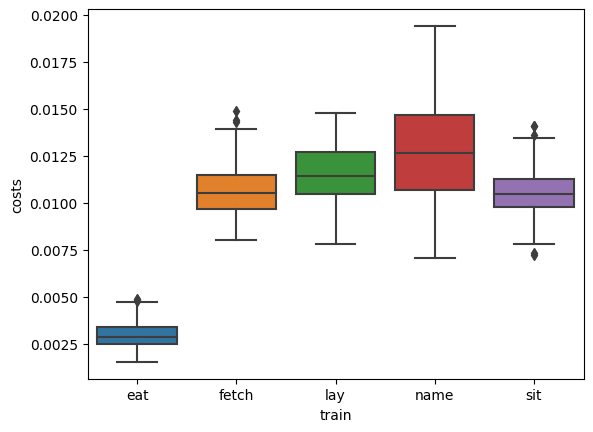

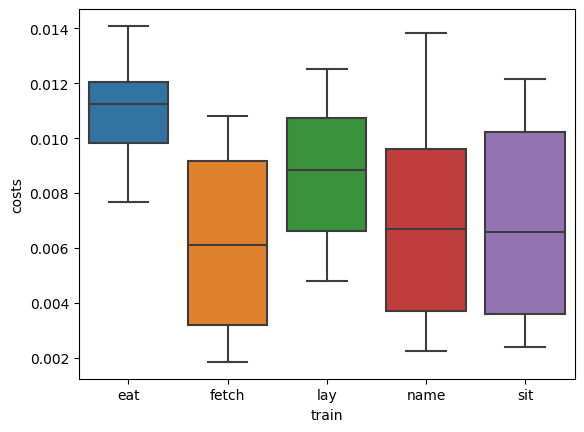

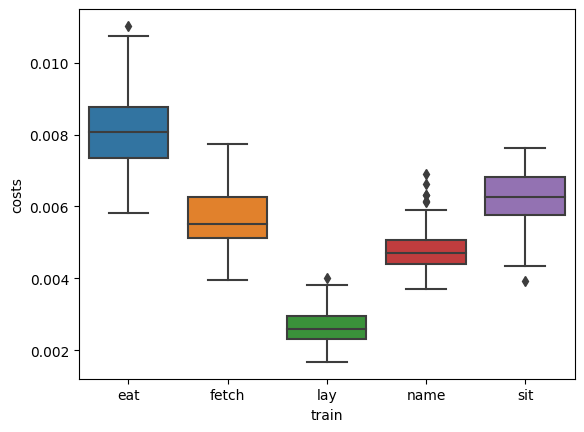

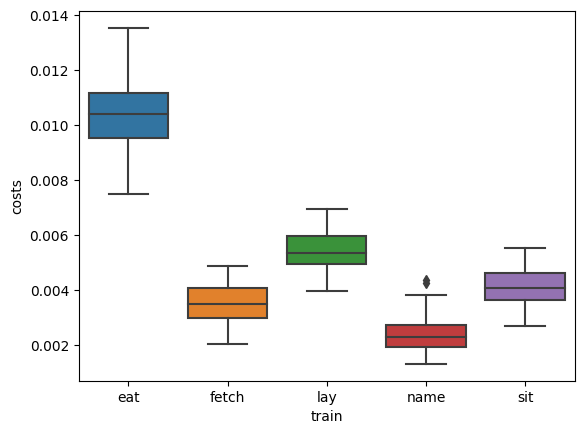

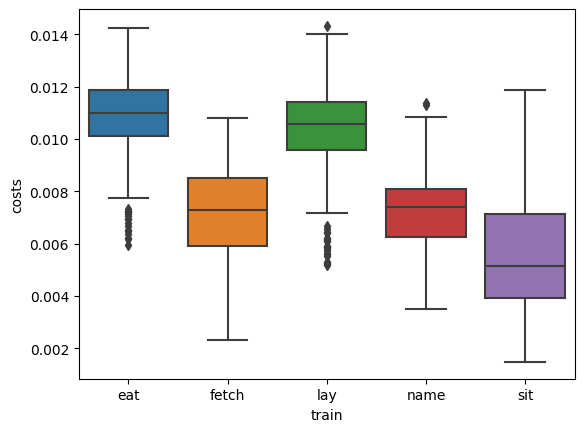

In [147]:
for test in tests:
    df = pd.DataFrame.from_dict(test_data)
    dfFilter = df[df['test'] == test]
    foo = dfFilter.explode('costs')
    plt.figure()
    sns.boxplot(data=foo, x="train", y="costs")

# Min, Avg and Max of all comparisons

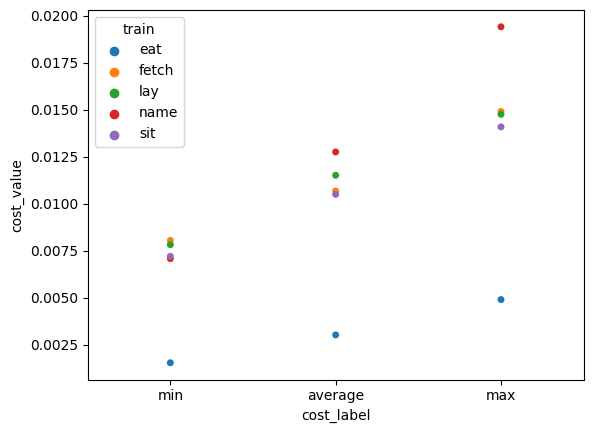

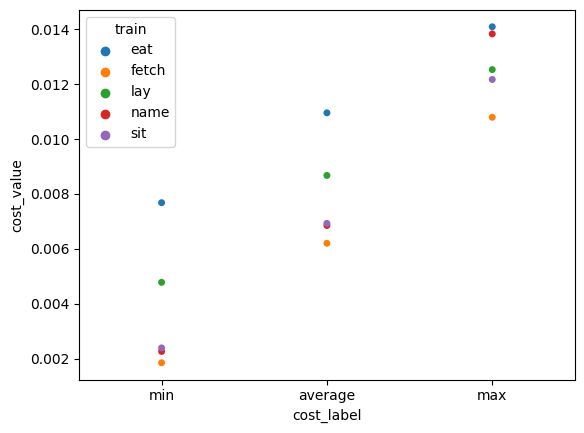

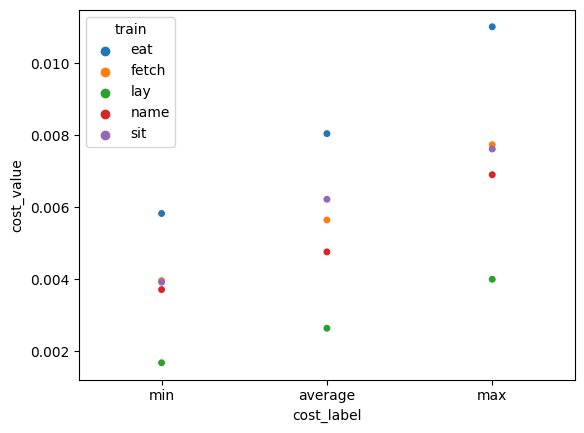

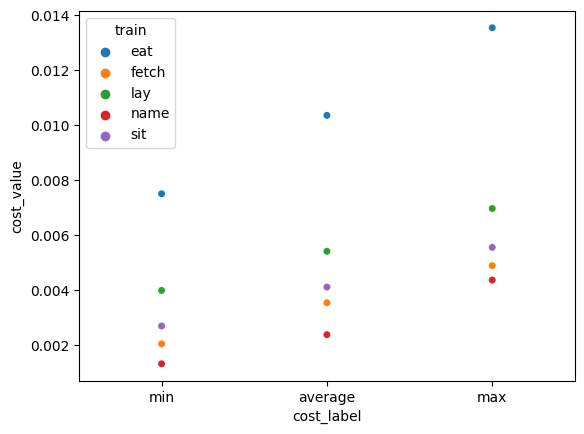

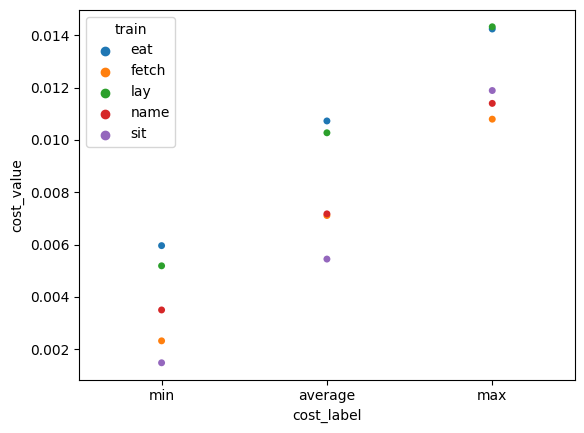

In [148]:
for test in tests:
    plot_train=[]
    plot_label=[]
    plot_value=[]
    for test_label, train_label, min_cost, avg_cost, max_cost in zip(test_data['test'], test_data['train'], test_data['min'], test_data['average'], test_data['max']):
        if test == test_label:
            plot_train.append(train_label)
            plot_train.append(train_label)
            plot_train.append(train_label)
            plot_label.append('min')
            plot_label.append('average')
            plot_label.append('max')
            plot_value.append(min_cost)
            plot_value.append(avg_cost)
            plot_value.append(max_cost)
    plot_data={'train': plot_train, 'cost_label': plot_label, 'cost_value': plot_value}
    df = pd.DataFrame.from_dict(plot_data)
    plt.figure()
    sns.stripplot(data = df,
              x='cost_label', y='cost_value', 
              order = ['min','average','max'],
              hue = 'train', jitter=False)

# Min, Avg and Max of all correct comparisons

In [149]:
plot_train=[]
plot_test=[]
plot_label=[]
plot_value=[]
correct_cat=[]
for test_label, train_label, min_cost, avg_cost, max_cost in zip(test_data['test'], test_data['train'], test_data['min'], test_data['average'], test_data['max']):
        if test_label == train_label:
            correct_cat.append('correct')
            correct_cat.append('correct')
            correct_cat.append('correct')
        else:
            correct_cat.append('incorrect')
            correct_cat.append('incorrect')
            correct_cat.append('incorrect')
        plot_train.append(train_label)
        plot_train.append(train_label)
        plot_train.append(train_label)
        plot_test.append(test_label)
        plot_test.append(test_label)
        plot_test.append(test_label)
        plot_label.append('min')
        plot_label.append('average')
        plot_label.append('max')
        plot_value.append(min_cost)
        plot_value.append(avg_cost)
        plot_value.append(max_cost)
plot_data={'test': plot_test,'train': plot_train, 'cost_label': plot_label, 'cost_value': plot_value, 'prediction': correct_cat}

Text(0.5, 0, 'Alignment Cost Category')

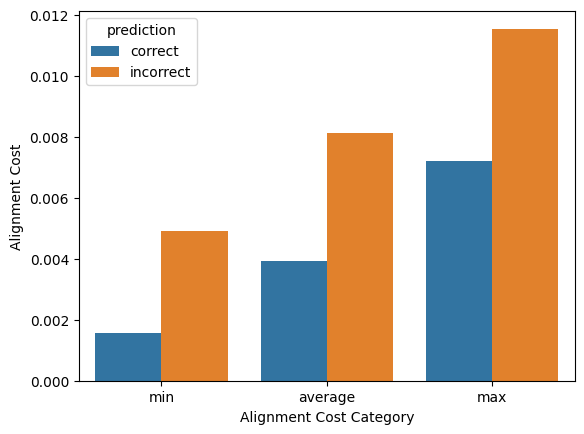

In [150]:
df = pd.DataFrame.from_dict(test_data_avg)
sns.barplot(data=df, x="category", y="cost", hue="prediction")
plt.ylabel('Alignment Cost')
plt.xlabel('Alignment Cost Category')

Text(0.5, 0, 'Alignment Cost Category')

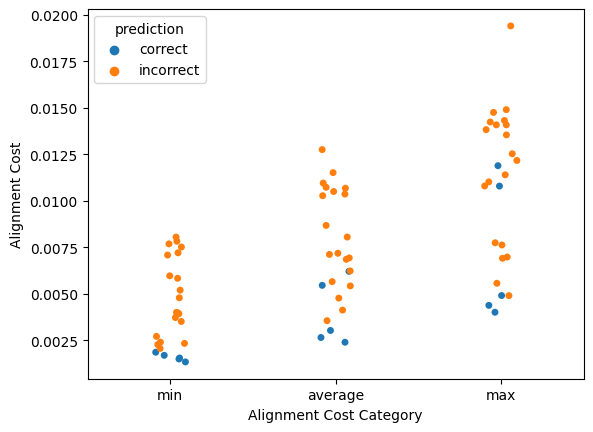

In [151]:
df = pd.DataFrame.from_dict(plot_data)
sns.stripplot(data = df,
          x='cost_label', y='cost_value', 
          order = ['min','average','max'],
          hue = 'prediction', jitter=True)
plt.ylabel('Alignment Cost')
plt.xlabel('Alignment Cost Category')

<AxesSubplot:xlabel='cost_label', ylabel='cost_value'>

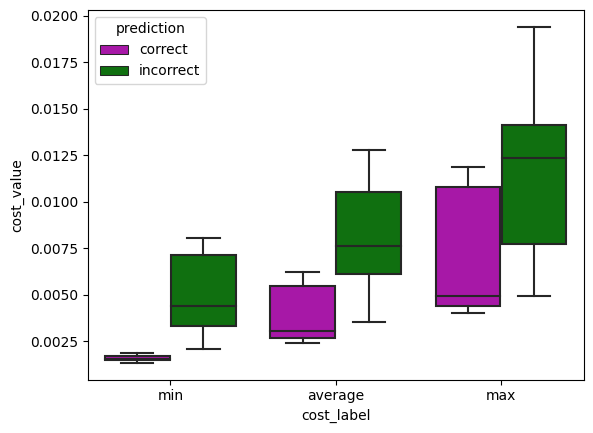

In [152]:
df = pd.DataFrame.from_dict(plot_data)
sns.boxplot(x="cost_label", y="cost_value",
            hue="prediction", palette=["m", "g"],
            data=df)

<AxesSubplot:xlabel='cost_label', ylabel='cost_value'>

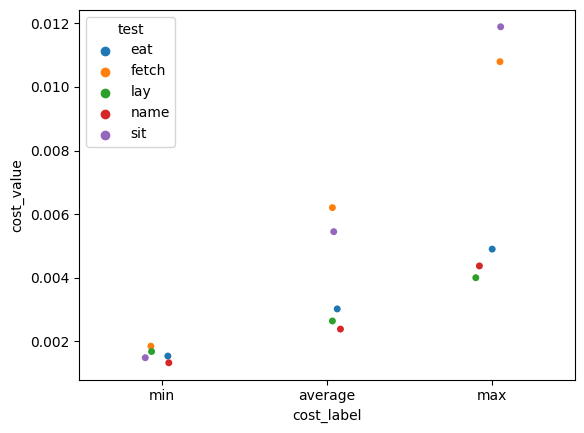

In [153]:
df = pd.DataFrame.from_dict(plot_data)
df = df[df['test'] == df['train']]
sns.stripplot(data = df,
          x='cost_label', y='cost_value', 
          order = ['min','average','max'],
          hue = 'test', jitter=True)

# Cost of all training comparisons for each test type

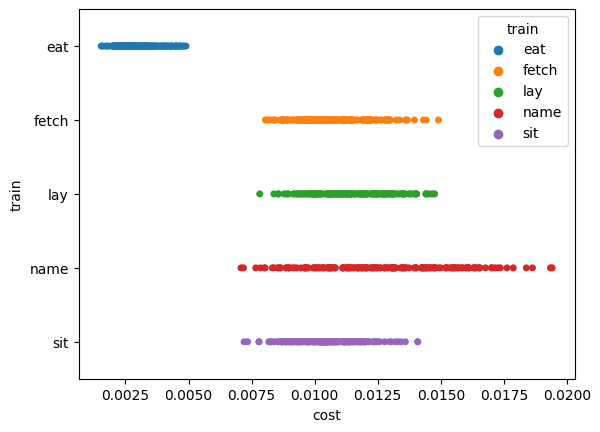

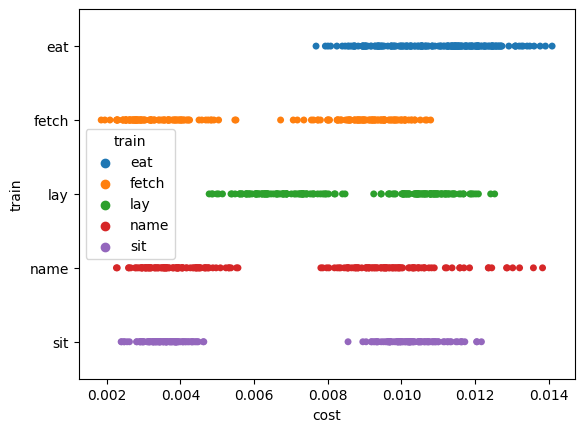

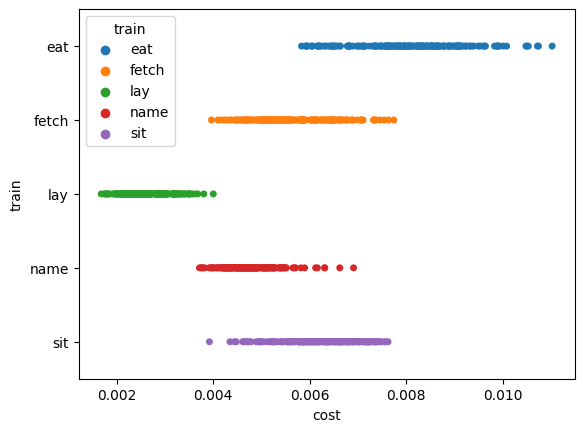

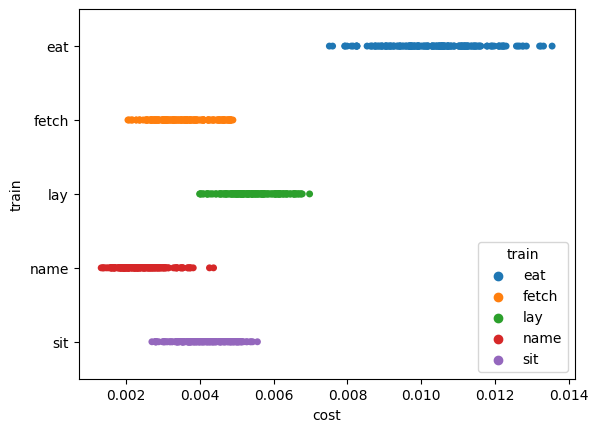

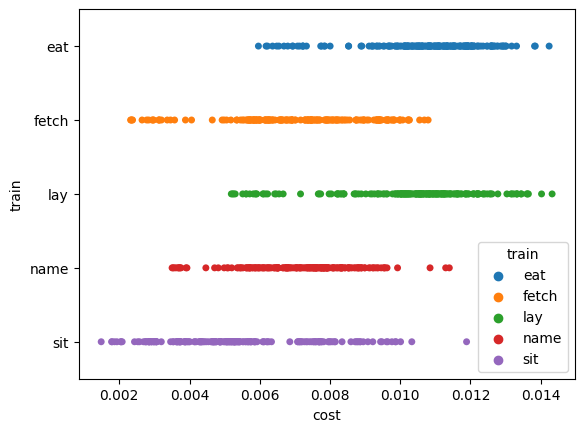

In [154]:
for test in tests:
    df = pd.DataFrame.from_dict(all_comp)
    df = df[df['test'] == test]
    plt.figure()
    sns.stripplot(data = df,
          x='cost', y='train', 
          hue = 'train', jitter=False)

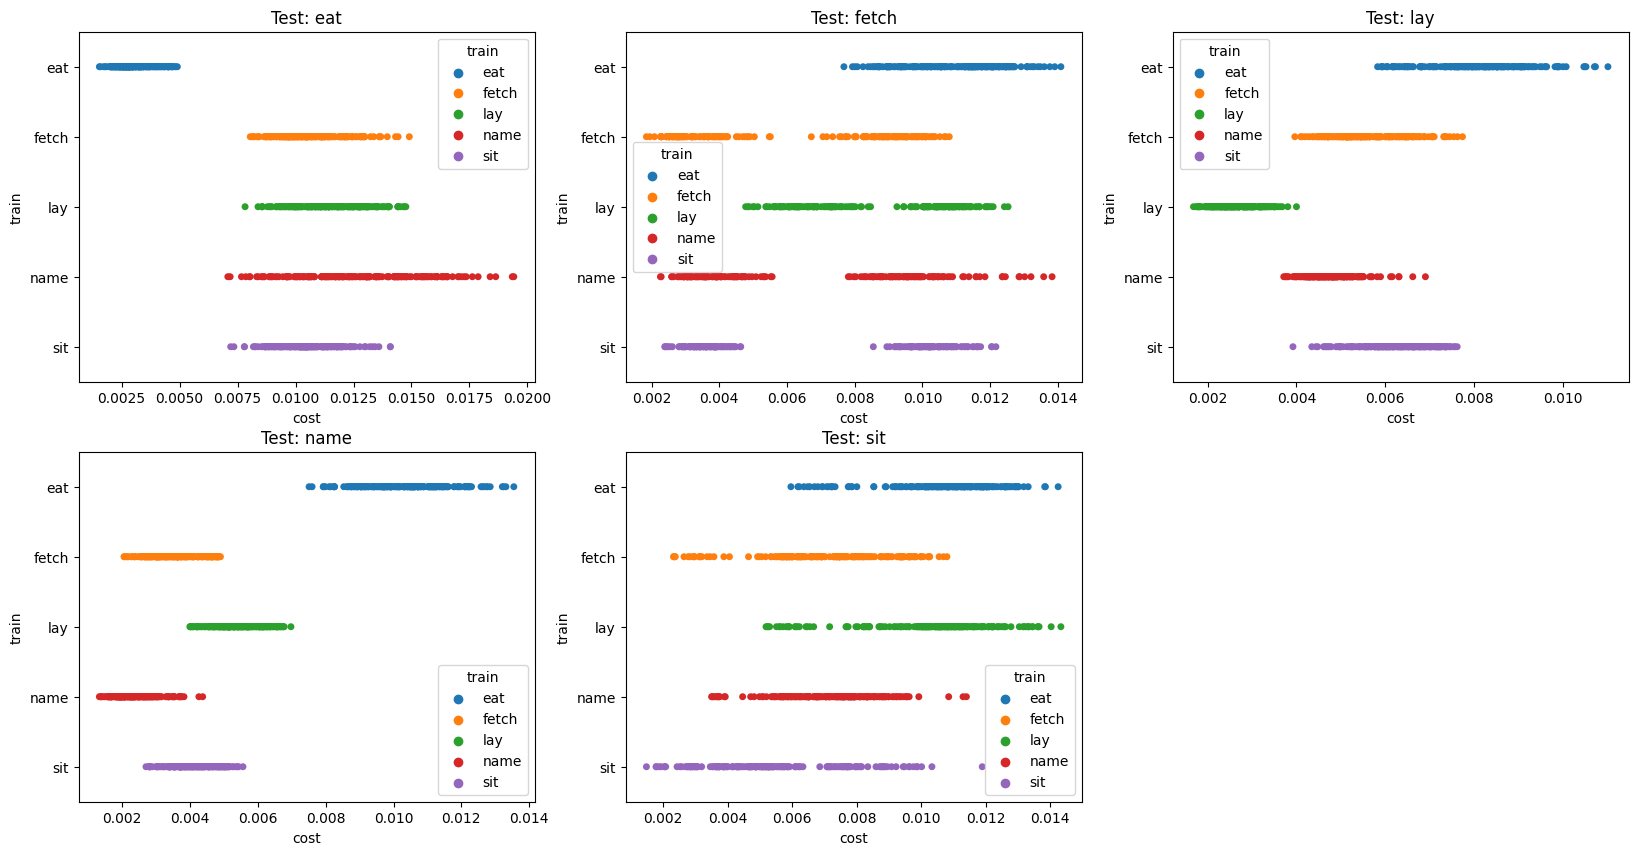

In [155]:
fig=plt.figure(figsize=(20,10))
columns = 3
rows = 2
for i in range(1, 6):
    fig.add_subplot(rows, columns, i)
    df = pd.DataFrame.from_dict(all_comp)
    df = df[df['test'] == tests[i-1]]
    sns.stripplot(data = df,
          x='cost', y='train', 
          hue = 'train', jitter=False).set(title='Test: '+tests[i-1])
plt.show()

# Cost of all training comparisons for each test type combined

<AxesSubplot:xlabel='cost', ylabel='test'>

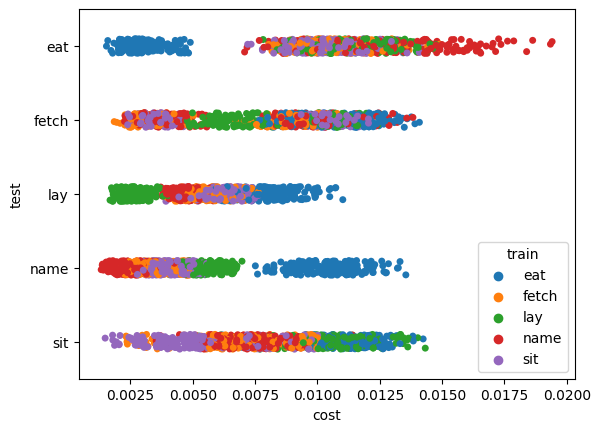

In [156]:
df = pd.DataFrame.from_dict(all_comp)
plt.figure()
sns.stripplot(data = df,
      x='cost', y='test', 
      hue = 'train', jitter=True)

# Cost of all training correct comparisons for each test type combined

<AxesSubplot:xlabel='cost', ylabel='test'>

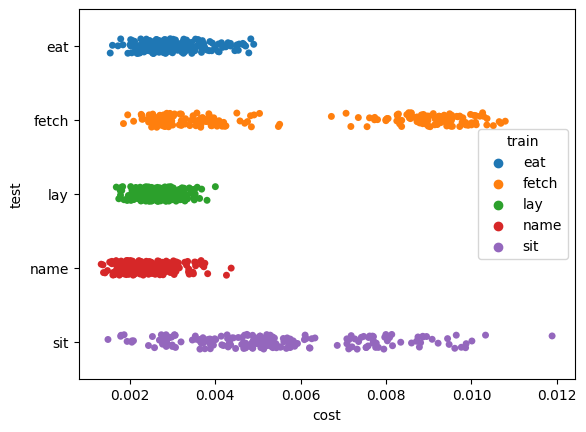

In [157]:
df = pd.DataFrame.from_dict(all_comp)
df = df[df['train'] == df['test']]
plt.figure()
sns.stripplot(data = df,
      x='cost', y='test', 
      hue = 'train', jitter=True)

# costs of all correct predictions combined

     test   pred      cost
0     eat    eat  0.002109
1     eat    eat  0.001538
2     eat    eat  0.002063
3     eat    eat  0.002017
4     eat    eat  0.002480
5     eat    eat  0.002161
6     eat    eat  0.002003
7     eat    eat  0.001784
8     eat    eat  0.001719
9     eat    eat  0.001591
10  fetch  fetch  0.002278
11  fetch  fetch  0.002508
12  fetch  fetch  0.007175
13  fetch  fetch  0.006719
14  fetch  fetch  0.007350
15  fetch  fetch  0.007062
16  fetch  fetch  0.001948
17  fetch  fetch  0.002264
18  fetch  fetch  0.001849
19  fetch  fetch  0.007555
20    lay    lay  0.001681
21    lay    lay  0.001991
22    lay    lay  0.002110
23    lay    lay  0.001979
24    lay    lay  0.001944
25    lay    lay  0.001800
26    lay    lay  0.002018
27    lay    lay  0.001774
28    lay    lay  0.001779
29    lay    lay  0.001739
30   name   name  0.001600
31   name   name  0.001417
32   name   name  0.001381
33   name   name  0.001576
34   name   name  0.001635
35   name   name  0.001596
3

<AxesSubplot:xlabel='cost', ylabel='test'>

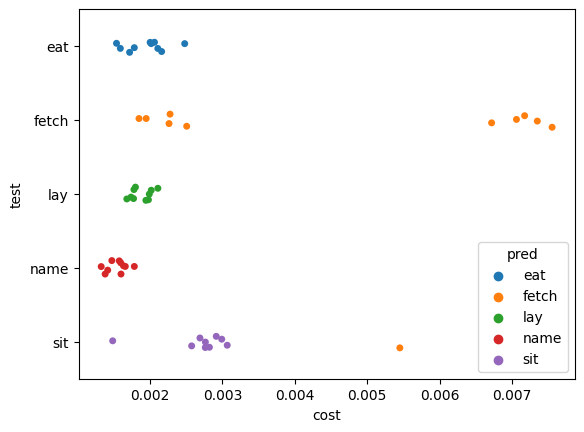

In [158]:

df = pd.DataFrame.from_dict(all_pred)
print(df)
plt.figure()
sns.stripplot(data = df,
      x='cost', y='test', 
      hue = 'pred', jitter=True)

# Cost span of all correct comparisons combined

1000


<AxesSubplot:xlabel='cost', ylabel='test'>

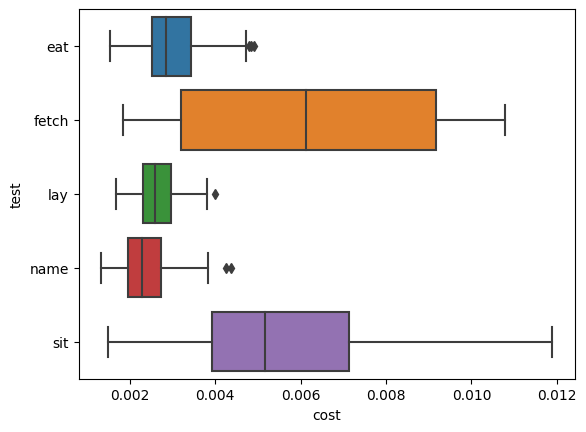

In [159]:
df = pd.DataFrame.from_dict(all_comp)
df = df[df['train'] == df['test']]
print(len(df['test']))
plt.figure()
sns.boxplot(data = df,
      x='cost', y='test')